In [629]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

# need exoplanet version 0.3.3 for the gp submodule. 
#Should upgrade specgp to use celerite2 eventually. 
import exoplanet as xo
import specgp as sgp
from specgp.distributions import MvUniform

In [630]:
data = np.loadtxt('K22b.dat')
t = data[:, -1]
data = data[:, :-1]

#b, g, r = [band/np.mean(band) for band in data.T]

estimated white noise: [0.00023436 0.00021331 0.00022494]


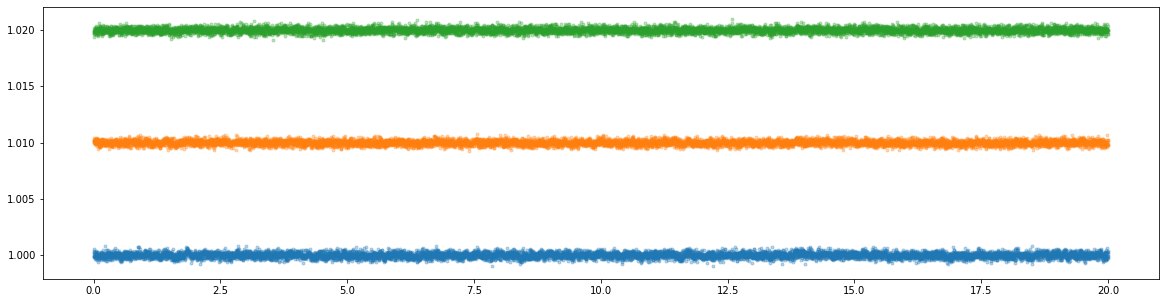

In [631]:
pl.figure(figsize=(20, 5))
for i, f in enumerate(data.T):
    pl.plot(t/(60*60), f/np.mean(f) + 0.01*i, '.', alpha=0.3)
wn_est = np.std(data/np.mean(data, axis=0), axis=0)
print("estimated white noise: {0}".format(wn_est))

In [632]:
obs = np.reshape(np.array([f/np.mean(f) for f in data.T]).T, (np.shape(data)[1]*len(t)))

def getmodel(holds={}, mu={}, sig={}, transform=False, nterms=1):
    
    params = ['logS0', 'logw', 'alpha', 
             'logsig', 'mean', 'u', 'logrp', 't0p', 't0m']
    for p in params:
        if p not in holds:
            holds[p] = None
        if p not in mu:
            mu[p] = None
        if p not in sig:
            sig[p] = None
    
    with pm.Model() as model:
        logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"], observed=holds['logS0'])
        logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"], observed=holds['logw'])
        
        if np.shape(data)[1] > 1:
            alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(data)[1]-1, observed=holds['alpha'])
        logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(data)[1], observed=holds['logsig'])
        mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(data)[1], observed=holds['mean'])
        u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
                                        testval=[0.5, 0.5], observed=holds['u'])
        
        if transform:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                               observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                             observed=holds['t0p'])
        else:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                           transform=None, observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                         transform=None, observed=holds['t0p'])
        
        orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
        lcp = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
        mean = mean[:, None] + lcp.T[0]
    
        term = xo.gp.terms.SHOTerm(
                log_S0 = logS0,
                log_w0 = logw,
                log_Q = -np.log(np.sqrt(2))
            )
        
        if np.shape(data)[1] > 1:
            a = tt.exp(tt.concatenate([[0.0], alpha]))
            kernel = sgp.terms.KronTerm(term, alpha=a)
        else:
            kernel = term
        
        yerr = tt.exp(2 * logsig)
        yerr = yerr[:, None] * tt.ones(len(t))
        
        if np.shape(data)[1] > 1:
            gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
        else:
            gp = xo.gp.GP(kernel, t, yerr[0], J=2, mean=mean)
        marg = gp.marginal("gp", observed = obs.T)
    return model

In [633]:
nb = np.shape(data)[1]
mu = {'logS0':np.log(8e-11), 'logw':np.log(866), 'alpha':np.zeros(nb-1), 
             'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 'logrp':np.log(0.01), 't0p':5}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
             'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 't0p':2}
m = getmodel(mu=mu, sig=sig)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


In [634]:
with m:
    map_soln = xo.optimize(start=m.test_point, verbose=True)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0p, logrp, u, mean, logsig, alpha, logw, logS0]


message: Desired error not necessarily achieved due to precision loss.
logp: 199685.49691683892 -> 202016.8490156021


In [635]:
np.exp(map_soln['logrp'])

0.005526147702376408

In [644]:
import copy
holds = copy.deepcopy(map_soln)
holds.pop('logrp')
astart = holds.pop('alpha')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')

start = {
    "alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrp": np.log(0.01)
}

t0grid = np.linspace(3, 7, 50)
ll = np.zeros_like(t0grid)
r = np.zeros_like(t0grid)
for i, t0 in enumerate(t0grid):
    holds['t0p'] = t0
    m = getmodel(holds=holds, mu=mu, sig=sig)
    with m:
        print('\r{0}/{1}'.format(i+1, len(t0grid)), end='')
        newmap_soln = xo.optimize(start=start, verbose=True)
        ll[i] = m.logp(newmap_soln)
        r[i] = np.exp(newmap_soln['logrp'])

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
1/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201699.7215097505 -> 202184.57107756098


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
2/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201692.72639771266 -> 202184.5710773487


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
3/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201689.7081621598 -> 202184.57107752154


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
4/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201693.66503850024 -> 202184.57107756025


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
5/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201691.66026016133 -> 202184.57107742


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
6/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201704.528542201 -> 202184.57107755815


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
7/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201716.1354303204 -> 202184.57107751555


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
8/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201727.24881423046 -> 202184.57107749768


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
9/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201729.35907355786 -> 202184.57107757244


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
10/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201738.31596483858 -> 202184.57107743013


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
11/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201751.67792203958 -> 202184.59184393968


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
12/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201753.6468647852 -> 202184.61363870787


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
13/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201762.23883089563 -> 202184.83588599472


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
14/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201761.19753908197 -> 202184.7965070513


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
15/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201764.71531005675 -> 202184.9244580072


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
16/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201772.7885679788 -> 202185.38297194307


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
17/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201774.28509057712 -> 202185.49846183587


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
18/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201781.5294155974 -> 202186.05599036792


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
19/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201783.24237146028 -> 202186.1614125172


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
20/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201792.61179554902 -> 202187.12211335896


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
21/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201803.52274822484 -> 202188.5363559799


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
22/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201808.8839743448 -> 202189.29676824904


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
23/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201816.13881412795 -> 202190.4487361456


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
24/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201825.56039566745 -> 202192.04500250795


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
25/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201827.8666074313 -> 202192.5460020166


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
26/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201820.32219147278 -> 202191.0425337724


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
27/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201802.91221525118 -> 202188.26305244613


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
28/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201795.43739385612 -> 202187.33572965852


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
29/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201783.46794217968 -> 202186.13533301782


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
30/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201778.64688509793 -> 202185.6916771152


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
31/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201781.51509394142 -> 202185.8852489604


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
32/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201789.03519057567 -> 202186.51834365213


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
33/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201789.43245213723 -> 202186.576878174


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
34/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201788.34060648317 -> 202186.45497066257


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
35/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201787.5768198255 -> 202186.3189947191


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
36/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201770.1210144131 -> 202185.05773305334


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
37/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201762.72854923867 -> 202184.7711257648


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
38/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201754.02121202205 -> 202184.58925669992


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
39/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201744.6135800311 -> 202184.5710775117


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
40/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201733.69801686401 -> 202184.57107754768


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
41/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201726.4235203613 -> 202184.57107754023


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
42/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201726.26835577367 -> 202184.57107757623


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
43/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201719.70770390917 -> 202184.5710775139


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
44/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201726.43734074326 -> 202184.57107735498


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
45/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201729.2999827664 -> 202184.57107749052


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
46/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201719.52953672947 -> 202184.57107749535


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
47/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201719.77419016068 -> 202184.5710774776


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
48/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201726.18752503968 -> 202184.57107749677


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
49/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201735.52306102647 -> 202184.5710774758


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
50/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig, alpha]


message: Desired error not necessarily achieved due to precision loss.
logp: 201743.2587965785 -> 202184.5710774819


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


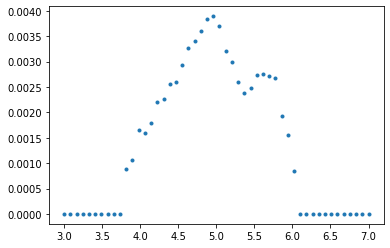

In [645]:
pl.plot(t0grid, r, '.')

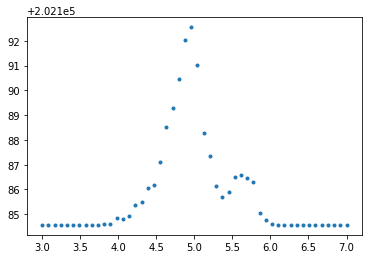

In [646]:
pl.plot(t0grid, ll, '.')

In [652]:
mu = {'logS0':np.log(8e-11), 'logw':np.log(866), 'alpha':np.zeros(nb-1), 
      'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 
      'logrp':np.log(0.0001), 'logrm':np.log(0.004), 't0p':10, 't0m':5}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
       'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 't0p':1, 't0m':1}

with pm.Model() as model:
    logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"])
    logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"])
    alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(data)[1]-1)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(data)[1])
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(data)[1])
    #u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
    #                                    testval=[0.5, 0.5])
    u1 = pm.Uniform("u1", lower=0, upper=1, testval=0.5)
    u2 = pm.Uniform("u2", lower=0, upper=1, testval=0.5)
    u = [u1, u2]
    #logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
    #                       transform=None)
    #t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
    #                     transform=None)
    logrm = pm.Uniform("logrm", lower=-20.0, upper=0.0, testval=mu['logrm'], 
                           transform=None)
    t0m = pm.Normal("t0m", mu=mu['t0m'], sd=sig['t0m'], testval=mu['t0m'], 
                         transform=None)
        
    orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
    #lcp = (xo.LimbDarkLightCurve(u)
    #          .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
    lcm = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrm), t=t/(60*60)-t0m, texp=np.mean(np.diff(t))/(60*60)))
    mean = mean[:, None] + lcm.T[0]
    
    term = xo.gp.terms.SHOTerm(
            log_S0 = logS0,
            log_w0 = logw,
            log_Q = -np.log(np.sqrt(2))
        )
        
    a = tt.exp(tt.concatenate([[0.0], alpha]))
        
    kernel = sgp.terms.KronTerm(term, alpha=a)
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
    marg = gp.marginal("gp", observed = obs.T)
        
    trace = pm.sample(
        tune=500,
        draws=500,
        start=model.test_point,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]
INFO:pymc3:NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 9670 seconds.
INFO:pymc3:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 9670 seconds.


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8309598746057573, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


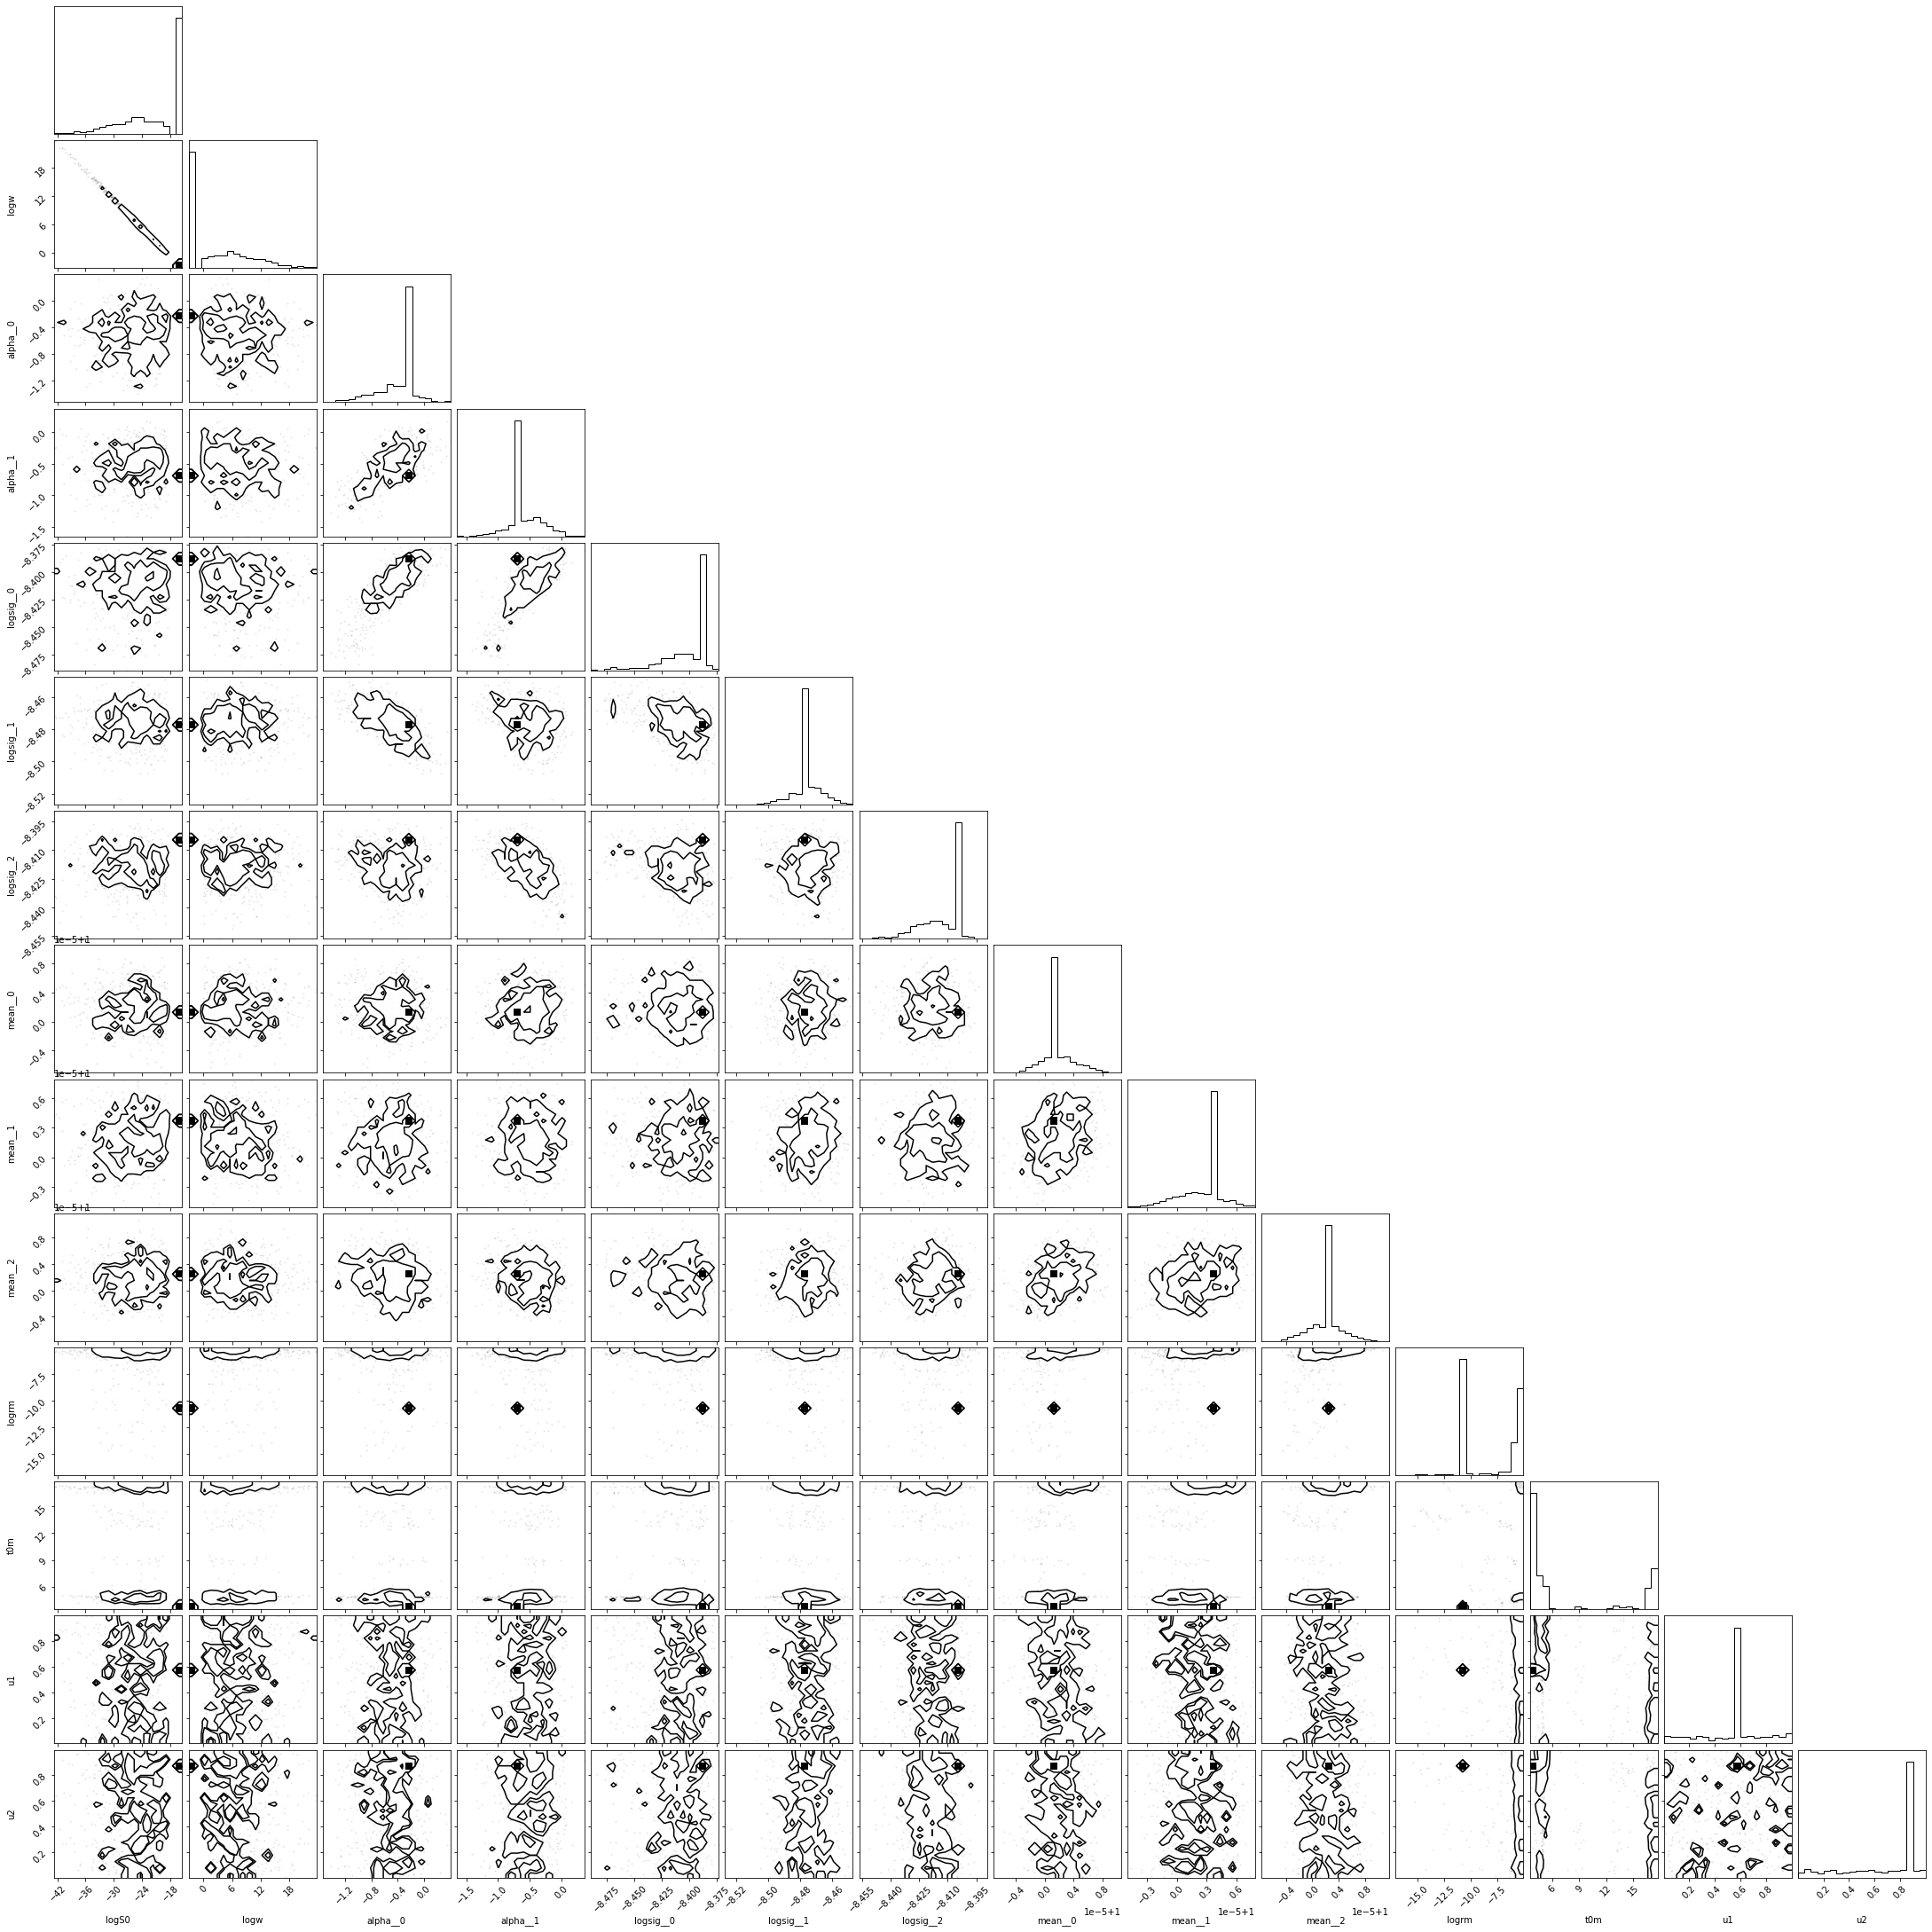

In [651]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)